# Learning CStree using Gibbs sampler

This notebook shows how to learn a CStree from observational data using McMC (Gibbs) sampling to approximate the posterior order distribution. 

In [70]:
import sys
import logging
import random

from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import chisq

import pandas as pd
import matplotlib.pyplot as plt
import cstrees.cstree as ct
import cstrees.scoring as sc
import cstrees.stage as st
import cstrees.learning as ctl
import networkx as nx
import numpy as np
import pp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Sample a random CStree

We sample a 4-variables random CStree.

In [71]:
np.random.seed(22)
random.seed(22)
p = 4
cards = [2] * p  # state space cardinalities

t = ct.sample_cstree(cards, max_cvars=2, prob_cvar=0.5, prop_nonsingleton=1)
t.labels = ["a", "b", "c", "d"]
t.sample_stage_parameters(alpha=2)

In [72]:
t.sample(10)

,a,b,c,d
0,2,2,2,2
1,1,0,1,1
2,1,0,0,1
3,1,0,1,1
4,1,1,1,0
5,1,0,1,1
6,1,0,1,1
7,1,0,1,1
8,1,0,0,1
9,1,0,0,1


Plot the part of the tree that was used for sampling data

Use plot(full=True) to draw the full tree.


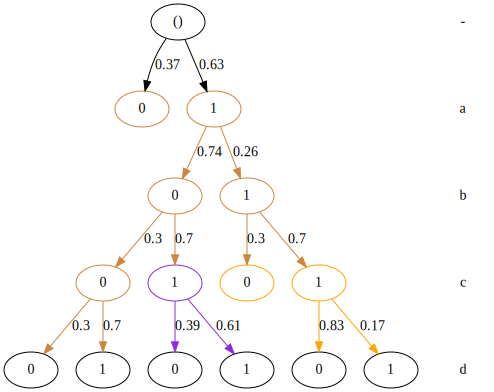

In [73]:
t.plot()

In [74]:
t.sample(5)

,a,b,c,d
0,2,2,2,2
1,0,0,1,1
2,0,0,1,1
3,1,1,1,0
4,1,1,1,0
5,1,0,0,0


Use plot(full=True) to draw the full tree.


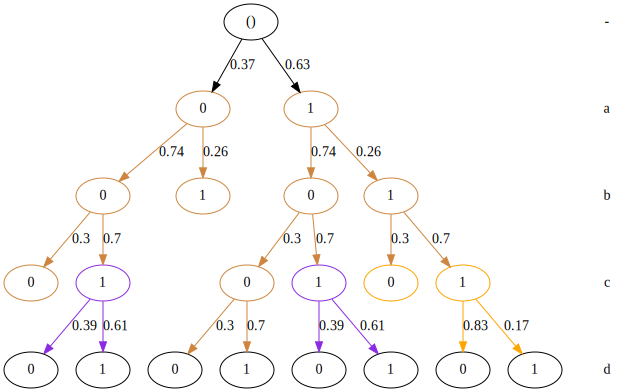

In [75]:
t.plot()

Get the minimal context DAGs

In [76]:
agraphs = t.to_minimal_context_agraphs()
print("Number of minimal contexts:", len(agraphs))

Number of minimal contexts: 2


Context: None


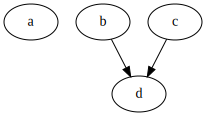

In [77]:
keys = list(agraphs.keys())
print("Context:", keys[0])
agraphs[keys[0]]

Context: b=1


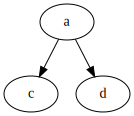

In [78]:
keys = list(agraphs.keys())
print("Context:", keys[1])
agraphs[keys[1]]

In [79]:
np.random.seed(6)
x = t.sample(2000)

## Create the score tables

When creating the score tables, we restrict the possible context variables for each node by the parents estimated by PC algorithm.

In [94]:
pcgraph = pc(x[1:].values, 0.05, "chisq", node_names=x.columns)
poss_cvars = ctl.causallearn_graph_to_posscvars(pcgraph, labels=x.columns)
print("Possible context variables per node:", poss_cvars)

Depth=1, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 1812.38it/s]

Possible context variables per node: {'a': [], 'b': ['d'], 'c': ['d'], 'd': ['b', 'c']}


Create the score tables

In [81]:
score_table, context_scores, context_counts = sc.order_score_tables(
    x, max_cvars=2, alpha_tot=1.0, method="BDeu", poss_cvars=poss_cvars
)

Creating #stagings tables: 100%|██████████| 4/4 [00:00<00:00, 16070.13it/s]


Order score tables: 100%|██████████| 4/4 [00:00<00:00, 5970.54it/s]


## Run the Gibbs sampler

In [82]:
orders, scores = ctl.gibbs_order_sampler(5000, score_table)

Gibbs order sampler: 100%|██████████| 5000/5000 [00:00<00:00, 18999.33it/s]


### Trajectory score plots

We plot the first 200 iterations of the order score trajectory.

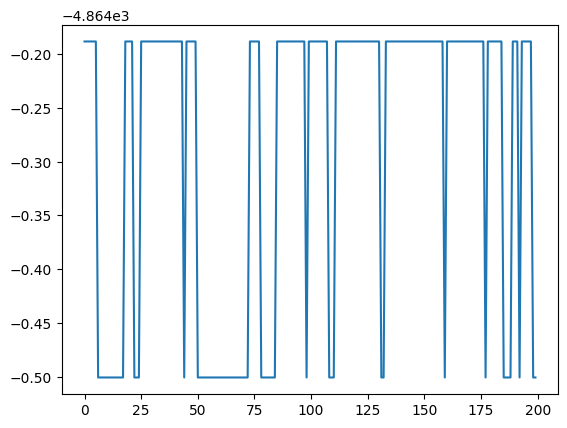

In [83]:
plt.plot(scores[:200]);

### Variables order positions

To further investigate the McMC trajectory we find the individual variables positions/levels in the orders and plot these. This gives an overview of the mixing properties of the sampler and if the trajectory seems to have converged.

In [84]:
var_positions = {var: [x.index(var) for x in orders] for var in orders[0]}
var_positions["iteration"] = list(range(len(orders)))
plotdf = pd.DataFrame(var_positions)

Assuming that the majority of probability mass is centered around the order corresponding to the true CStree (though there could be many or them), the a-line should converge to 0 (i.e. position 0), the b-line should converge to 1, and so on.

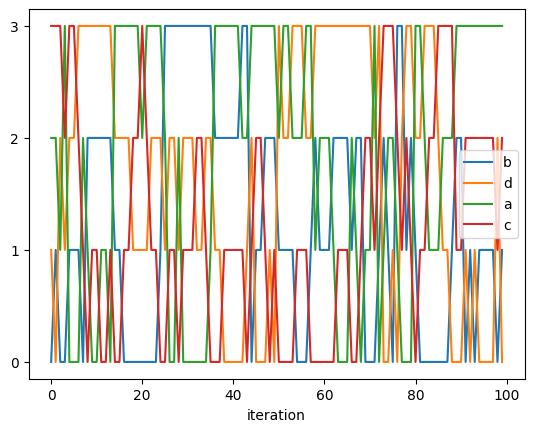

In [85]:
plotdf[:100].plot(x="iteration", y=range(p), yticks=range(len(orders[0])));

### Get the maximal scoring order

In [86]:
maporder = orders[scores.index(max(scores))]
maporder

['b', 'd', 'a', 'c']

### Get the maximal scoring CStree for the order

In [87]:
opttree = ctl._optimal_cstree_given_order(maporder, context_scores)

In [88]:
opttree.to_df()

,b,d,a,c
0,2,2,2,2
1,0,-,-,-
2,1,-,-,-
3,*,*,-,-
4,*,*,*,-
5,-,-,-,-


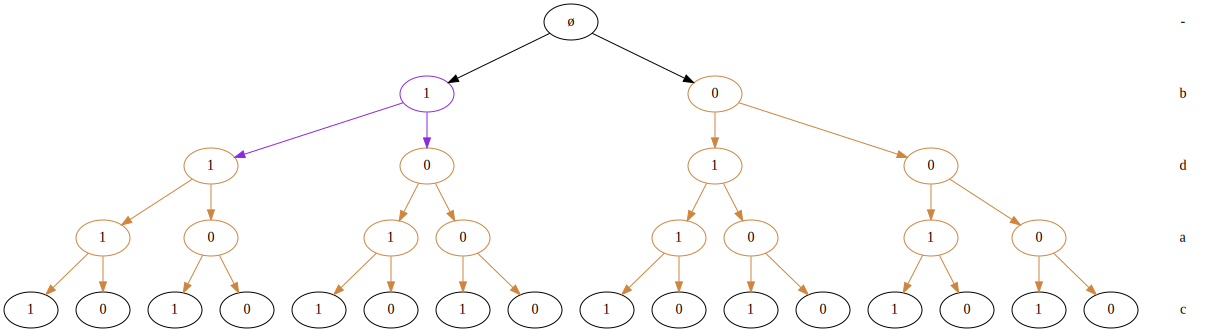

In [89]:
opttree.plot(full=True)

## Estimate the CStree parameters

In [90]:
opttree.estimate_stage_parameters(x, alpha_tot=2.0, method="BDeu")

opttree.to_df(write_probs=True)

,b,d,a,c,PROB_0,PROB_1
0,2,2,2,2,NaN,NaN
1,0,-,-,-,0.352174,0.647826
2,1,-,-,-,0.847140,0.152860
3,*,*,-,-,0.353646,0.646354
4,*,*,*,-,0.300699,0.699301
5,-,-,-,-,0.746753,0.253247


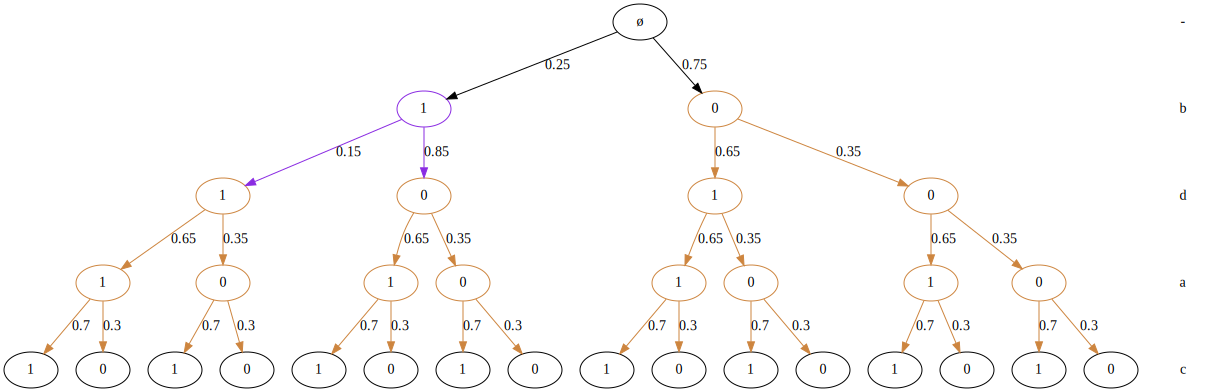

In [91]:
opttree.plot(full=True)

## Plot the DAG representation

In [92]:
agraphs = opttree.to_minimal_context_agraphs()
len(agraphs)

1

None


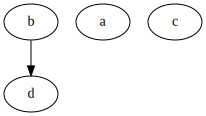

In [93]:
keys = list(agraphs.keys())
print(keys[0])
agraphs[keys[0]]